# Quantum Variational classifier
The current quantum computing technologies need quantum algorithms that require a limited number of qubits and quantum gates, and which are robust against errors. A suitable design approach are variational circuits where the parameters of gates are learnt, an approach that is particularly fruitful for applications in machine learning. Machine learning is data-driven decision making in which a computer fits a mathematical model to data (training) and uses the model to derive decisions (inference). Variational quantum classifiers (VQCs) are a type of hybrid quantum machine learning algorithm that can be used to solve a wide variety of classification problems. VQCs combine the power of quantum computing with the flexibility of classical machine learning algorithms to achieve better performance. 

VQCs work by first encoding the data into a quantum state. This is done using a feature map, which is a quantum circuit that takes the data as input and produces a quantum state as output. The quantum state is then passed to a variational quantum circuit, which is a quantum circuit that can be parameterized by a set of parameters.

The parameters of the variational quantum circuit are then optimized using a classical machine learning algorithm to minimize a loss function. The loss function is a measure of how well the VQC is able to classify the data.

Once the parameters of the variational quantum circuit have been optimized, the VQC can be used to classify new data points. To do this, the data point is encoded into a quantum state using the feature map, and then the quantum state is passed to the variational quantum circuit. The variational quantum circuit then produces a probability distribution over the different classes. The class with the highest probability is then predicted as the class of the data point. In fact, Quantum circuits that can be trained from labelled data to classify new data samples. 

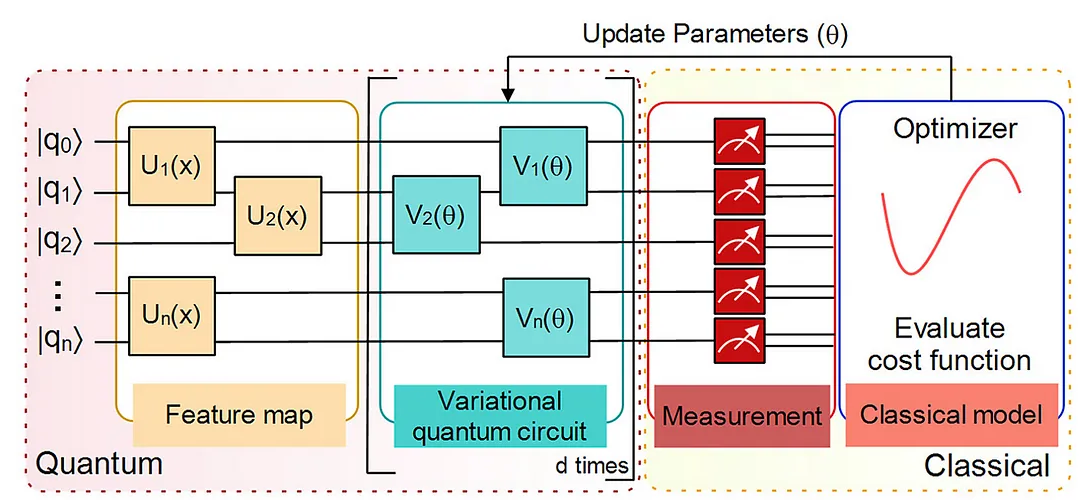

We introduce two examples used the variational circuits as supervised machine learning models. We will first show that the variational quantum classifier can produce the parity function

$$ f: x \in \{ 0, 1\}^\otimes{^n} → y = 
     \begin{cases}
       \text{1,} &\quad\text{if uneven number of 1's in x}\\
       \text{0.} &\quad\text{Otherwise}\\
     \end{cases}
$$

The first optimization example demonstrates how to encode binary inputs into the initial state of the variational circuit, which is simply a computational basis state (basis encoding).

The second example shows how to encode real vectors as amplitude vectors into quantum states (amplitude encoding) and how to train a variational circuit to recognize the first two classes of flowers in the Iris dataset.

For both examples, we create a quantum machine learning program in PennyLane as follows:
1. Define a device and a “layer” of varaitional circuits including the device type ,the number of wires and the layer weights .
2. Encode data inputs (State Preparation).
3. Define the quantum circuit including calling state preparation, followed by a repetition of the layer structure (QNode).
4. Define a cost function.
5. Import dataset, preprocessing and initialize the variables randomly
5. Perform the optimization

    i. Choose an optimizer and a step size (learning rate).
    
    ii. Choose batch size. 
    
    iii. Iterate over a number of defined steps.

6. Observe the results and model accuracy by printing or graphing them!


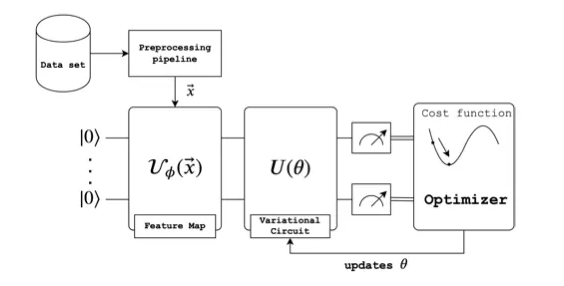

# 1. The parity function emulation
Our goal is to produce the parrity function using variational quantum classifier. In this example, we shift labels from {0, 1} to {-1, 1}. 

$$ f: x \in \{ 0, 1\}^\otimes{^n} → y = 
     \begin{cases}
       \text{1,} &\quad\text{if uneven number of 1's in x}\\
       \text{0.} &\quad\text{Otherwise}\\
     \end{cases}
$$

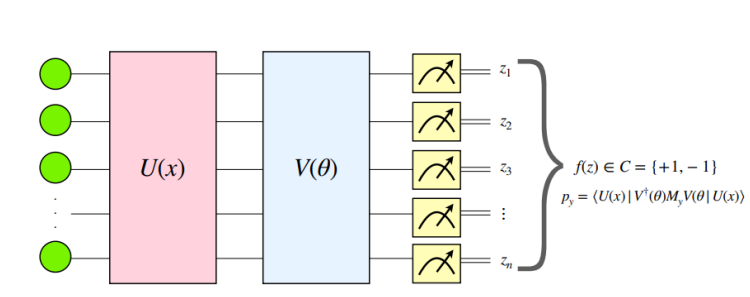


For example, in the case of 4 qubits, there are $2^4$ possible basis states:
0000

0001

.
.
.

1110

1111

We compute the parity of the basis states and sum the expectation value based on the result

$ f(0000) = 0 → 0.2 $

$ f(0001) = 0 → 0.1 $

$ \sum\limits_{i}{<z_i>} $ for basis states with even parity is mapped to P (C = 1)


### Imports our necessary libraries
In this example, we use Nesterov Momentum optimizer which required the learning rate schedule and momentum parameters. This optimizer is a method for unconstrained convex minimization problem with high rate of convergence.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

## Step 1 : Define a device and a “layer” of varaitional circuits
We create a quantum device that will run our circuits (pennylane simulator).

In [2]:
dev = qml.device("default.qubit")

Layer architectures define sequences of trainable gates that are repeated the similar layers in a neural network. Arbitrary templates or operations can also be repeated using the layer() function.

Variational classifiers usually define a “layer” or “block”, which is an elementary circuit architecture that gets repeated to build the full variational circuit.

Our circuit layer will use four qubits, or wires, for encoding of 4-bits binary string data inputs (basis embedding) and consists of an arbitrary rotation on every qubit, as well as a ring of CNOTs that entangles each qubit with its neighbour. The parameters of the layer is called weights as known in classical neural network.


In [3]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

Matplotlib is building the font cache; this may take a moment.


(<Figure size 800x500 with 1 Axes>, <Axes: >)

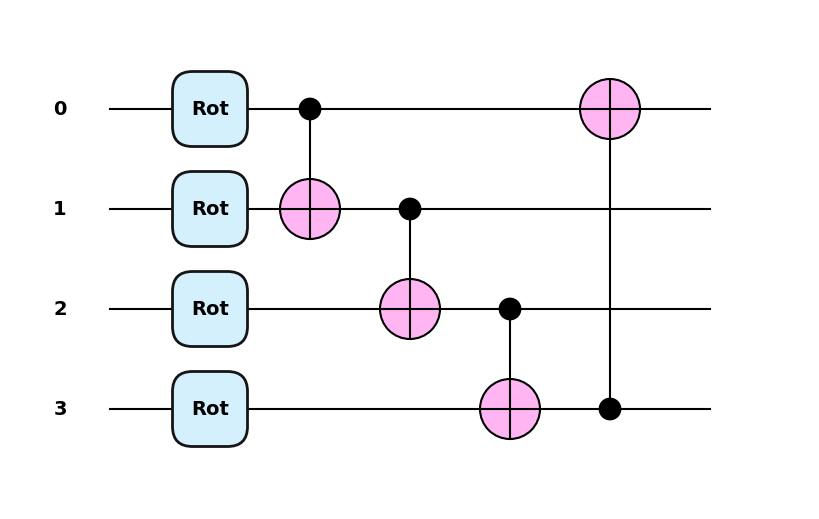

In [4]:
num_qubits = 4
num_layers = 2  # 2-layer Ansatz
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
qml.draw_mpl(layer, style='pennylane')(weights_init[0]) # show the first layer

Our layer architecture is very similar to BasicEntanglerLayers in pennylane. Layers consist of one-parameter single-qubit rotations on each qubit, followed by a closed chain or ring of CNOT gates. The ring of CNOT gates connects every qubit with its neighbour, with the last qubit being contsidered as a neighbour to the first qubit.
$$ BasicEntanglerLayers(weights, wires=None, rotation=None, id=None) $$

where weights is the tensor of shape (L, len(wires)). Each weights is used as a parameter for the rotation. 


### Step 2 Encode data inputs (State Preparation)
We also need a way to encode data inputs x into the circuit, so that the measured output depends on the inputs. In this first example, the inputs are bitstrings, which we simply encode our data into binary strings. We convert each input to a computational basis state of a qubit system. Basis embedding encodes n binary features into a basis state of n qubits. The quantum state ψ after state preparation is a computational basis state that has 1s where x has 1s, for example

$$ x = 0101 → |ψ⟩ = |0101⟩. $$

Some points to consider on basis embedding are:
- amplitude vectors become sparse in higher dimensions
- there is a lot of freedom to do computation
- schemes to implement it are usually not efficient.

Since our dataset has binary nature, so the basis embedding is suitable for encoding. The _BasisState_ function provided by PennyLane is made to do just this. It expects x to be a list of zeros and ones, i.e. [1,1,0,1].

In [5]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

## Step 3: Define the quantum circuit
The third step is the model circuit(ansatz), or the classifier. A parameterized unitary operator $ U(\theta)$ is created such that $|ψ(x: \theta)⟩ = U(\theta)|ψ(x)⟩ $ 

The model circuit is constructed from gates that evolve the input state. The circuit is based on unitary operations and depends on external parameters which will be adjustable. Given a prepared state|ψᵢ⟩ the model circuit,  $ U(\theta)$ maps |ψᵢ⟩ to another vector |ψᵢ⟩ =  $ U(\theta)$|ψᵢ⟩. In turn  $ U(\theta)$ consists of a series of unitary gates.

We define the variational quantum circuit including calling state preparation, followed by a repetition of the layer structure. As mentioned, it is very similar to BasicEntanglerLayers in pennylane. Increasing the depth of the variational circuit introduces more trainable parameters into the model.

In [6]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

(<Figure size 1400x500 with 1 Axes>, <Axes: >)

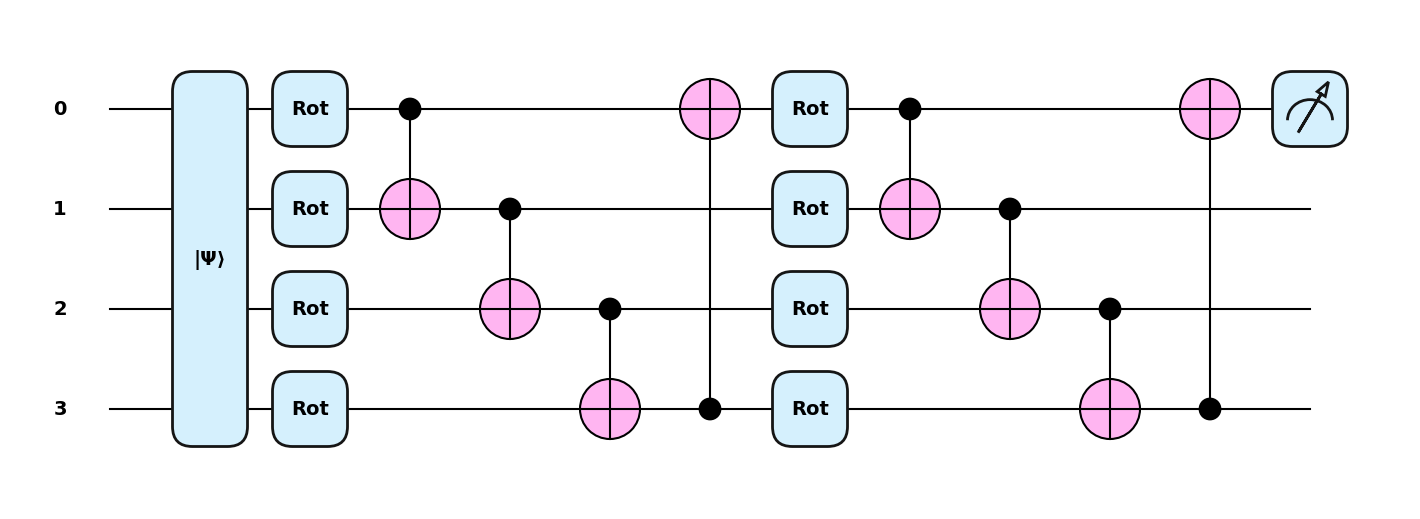

In [7]:
qml.draw_mpl(circuit, style='pennylane')(weights_init, [0,1,0,1])

This is a two-layer circuit, since the layer structure is repeated 2 times. At first we have arbitrary single qubit rotations for each qubit and the idea here is to insert some degree of superposition on each qubit separately. These rotations are parameterized and on each interaction of the algorithm these parameters will be updated by the classic computer. Besides, we are talking about rotations because the vectorial space of a qubit is the Bloch Sphere. This ansatz almost covers all pure states on surface of the Bloch Sphere. 

After that we have four Controlled-NOT (CNOT) states between each pair of qubits, which is a quantum gate that inverts a qubit state depending on the state of the other qubit (target and control, respectively). Thereby, this gate entangles all qubits in our circuit and now all states are entangled. In the second layer we apply a new set of rotations, which is not simply a logical repetition of the first layer because now all states are entangled, which means that rotating the first qubit will also affect the others! And finally we have a new set of CNOT gates.

In the measurement step, it estimates the probability of belonging to a class by performing certain measurements. It’s the equivalent of sampling multiple times from the distribution of possible computational basis states and obtaining an expectation value.

PennyLane can extract different types of measurement results from quantum devices: the expectation of an observable, its variance, samples of a single measurement, or computational basis state probabilities. In this example, the circuit returns the expectation value of the PauliZ observable on wire 0.


If we want to add a “classical” bias parameter, the variational quantum classifier also needs some post-processing. We define the full model as a sum of the output of the quantum circuit, plus the trainable bias.

In [8]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

## Step 4: Define a cost function
During training, we aim to find the values of parameters to optimize a given loss function. We can perform optimization on a quantum model similar to how it is done on a classical neural network. In both cases, we perform a forward pass of the model and calculate a loss function. We can then update our trainable parameters using gradient based optimization methods since the gradient of a quantum circuit is possible to compute. 

In supervised learning, the cost function is usually the sum of a loss function and a L1 or L2 regularizer. During training we use the mean squared error (MSE) as loss function (standard square loss). This allows us to measure a distance between model predictions and target labels, captured by the value of the loss function. 


In [9]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

To monitor how many inputs the current classifier predicted correctly, we also define the accuracy, or the proportion of predictions that agree with a set of target labels.

In [10]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

For learning tasks, the cost depends on the data - here the features and labels considered in the iteration of the optimization routine.

In [11]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

## Optimization
Let’s now load and preprocess some data.

### Note

The parity dataset’s train and test sets can be downloaded and should be placed in the subfolder variational_classifier/data.

In [12]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


We initialize the variables randomly (but fix a seed for reproducibility). Remember that one of the variables is used as a bias, while the rest is fed into the gates of the variational circuit.

In [13]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


Next we create an optimizer instance and choose a batch sizeand run the optimizer to train our model. We track the accuracy - the share of correctly classified data samples. For this we compute the outputs of the variational classifier and turn them into predictions in {−1, 1} by taking the sign of the output.

In [14]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

In [15]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

As we can see, the variational classifier learned to classify all bit strings from the training set correctly.

But unlike optimization, in machine learning the goal is to generalize from limited data to unseen examples. Even if the variational quantum circuit was perfectly optimized with respect to the cost, it might not generalize, a phenomenon known as overfitting. The art of (quantum) machine learning is to create models and learning procedures that tend to find “good” minima, or those that lead to models which generalize well.

With this in mind, let’s look at a test set of examples we have not used during training:

In [16]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


The quantum circuit has also learnt to predict all unseen examples perfectly well! This is actually remarkable, since the encoding strategy creates quantum states from the data that have zero overlap – and hence the states created from the test set have no overlap with the states created from the training set. There are many functional relations the variational circuit could learn from this kind of representation, but the classifier chooses to label bit strings according to our ground truth, the parity function.

Let’s look at the second example, in which we use another encoding strategy.

# 2. Iris classification

We now move on to classifying data points from the Iris dataset, which are no longer simple bitstrings but represented as real-valued vectors. The vectors are 2-dimensional, but we will add some “latent dimensions” and therefore encode inputs into 2 qubits.

## Quantum and classical nodes
State preparation is not as simple as when we represent a bitstring with a basis state. Every input x has to be translated into a set of angles which can get fed into a small routine for state preparation. To simplify things a bit, we will work with data from the positive subspace, so that we can ignore signs (which would require another cascade of rotations around the Z-axis).

The circuit is coded according to the scheme in Möttönen, et al. (2004), or—as presented for positive vectors only—in Schuld and Petruccione (2018). We also decomposed controlled Y-axis rotations into more basic gates, following Nielsen and Chuang (2010).

In [17]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Let’s test if this routine actually works.

In [18]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


The method computed the correct angles to prepare the desired state!

### Note
The default.qubit simulator provides a shortcut to state_preparation with the command _qml.StatePrep(x, wires=[0, 1])_. On state simulators, this just replaces the quantum state with our (normalized) input. On hardware, the operation implements more sophisticated versions of the routine used above.

Since we are working with only 2 qubits now, we need to update the layer function. In addition, we redefine the cost function to pass the full batch of data to the state preparation of the circuit simultaneously, a technique similar to NumPy broadcasting.

In [19]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

## Data
We load the Iris data set. There is a bit of preprocessing to do in order to encode the inputs into the amplitudes of a quantum state. We will augment the data points by two so-called “latent dimensions”, making the size of the padded data point match the size of the state vector in the quantum device. We then need to normalize the data points, and finally, we translate the inputs x to rotation angles using the get_angles function we defined above.

Data preprocessing should always be done with the problem in mind; for example, if we do not add any latent dimensions, normalization erases any information on the length of the vectors and classes separated by this feature will not be distinguishable.

## Note

The Iris dataset can be downloaded here and should be placed in the subfolder variational_classifer/data.

In [20]:
data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


These angles are our new features, which is why we have renamed X to “features” above. Let’s plot the stages of preprocessing and play around with the dimensions (dim1, dim2). Some of them still separate the classes well, while others are less informative.

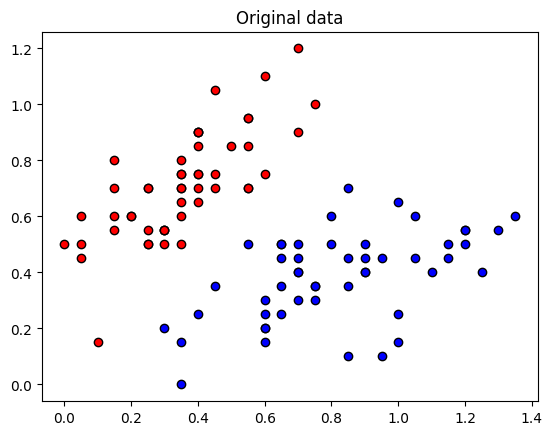

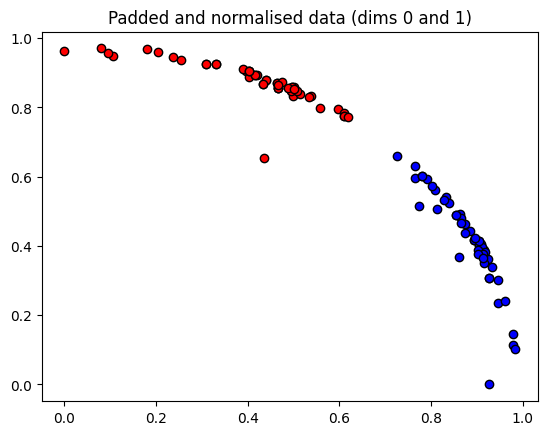

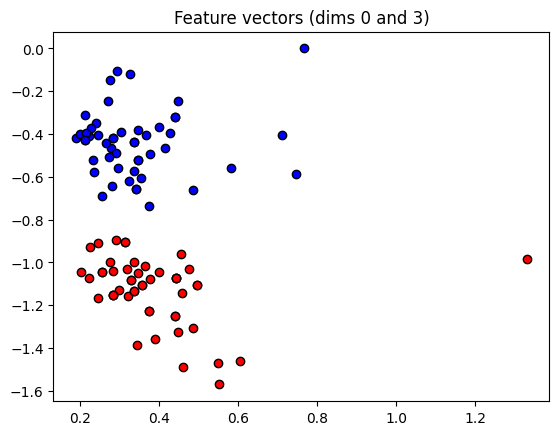

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()


This time we want to generalize from the data samples. This means that we want to train our model on one set of data and test its performance on a second set of data that has not been used in training. To monitor the generalization performance, the data is split into training and validation set.

In [22]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

## Optimization
First we initialize the variables.



In [23]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

Again we minimize the cost, using the imported optimizer.

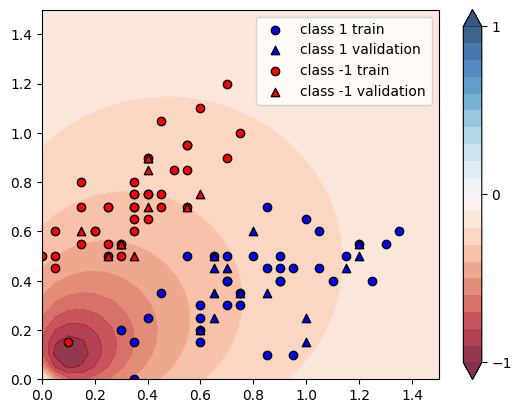

In [24]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()